# Missing Value Imputation Usong Conditional GAN

### Problem definition


1. <p style='text-align: justify;'> We've already seen that LSTM can act like generative model that can "predict future patches" given the "past patches"  <a href="https://github.com/Adham-M/Deep-Learning_ND/tree/main/Recurrent%20Neural%20Networks/RNN%20as%20a%20Generative%20Model/RNNs%20as%20a%20generative%20model.ipynb">here</a>. </p> 


2. <p style='text-align: justify;'> This time, we'll do something similar but by using GAN. This time, it works like a missing value imputation system. We assume that only the center part of the image is known, while the generator has to predict what the other surrounding pixels are. </p>


3. <p style='text-align: justify;'> We'll formulate this as a conditional GAN. First, take a batch of MNIST images. Take their center 10 x 10 patches, and then flatten it. This is your 100-dimensional conditioning vector. Since there are 28 x 28 pixels in each image, you'll do something like this, X[:,10:19,10:19], to take the center patch. This will form a B x 100 matrix. for your batch of B conditioning vectors. </p>


4. <p style='text-align: justify;'> Append this matrix to your random vectors of 100 dimensions drawn from the standard normal distribution. This <i>B</i> x 200 matrix is the input to your generator. </p>


5. <p style='text-align: justify;'> The generator takes this 200 dimensional vectors and synthesizes MNIST-looking digits. You will need to prepare another set of <i>B</i> real examples. Eventually, you feed <i>2B</i> examples in total to your discriminator as a minibatch. </p>


6. <p style='text-align: justify;'> If both discriminator and generator are trained properly, you can see that the results are some MNIST-looking digits. But, I found that the generator simply ignores the conditioning vector and generate whatever it wants to generate. They all certainly look like MNIST digits, but the conditioning part doesn't work. Below is the generated images (left) and the ground-truth images that I extracted the center patches from (right). 
<img src='assets/cgan_3.png' />

    They are completely different from each other. </p>


7. <p style='text-align: justify;'> So, even though I did feed the center patch as the conditioning vector to the generator, it ignores it and generate something totally different. It's because, I think, the generator has no way to know the conditioning vector is actually the center patch of the digit that it must generate. In other words, the generator is generating the whole image, although it doesn't have to generate the center patch, which is known to me. Instead, I wanted it to generate the surrounding pixels, that are the missing values. </p>


8. <p style='text-align: justify;'> As a remedy, I added another regularizer to my generator so that it functions as an autoencoder at least for the center pixels. You know, in an ordinary GAN setup, the generator loss has to penalize the discriminator's decision that classifies the fake examples into the fake class (i.e., when the generator fails to fool the discriminator). On top of this ordinary generator loss, I add a simple mean squared error term that penalizes the difference between the conditioning vector and the center patch of the generated image, as they have to be the same, essentially. </p>


9. <p style='text-align: justify;'> Since it's a regularizer, I needed to investigate different λ values to control its contribution to the total loss of the generator. It turned out that the generator is not too sensitive to this choice, although it does generate a "less conditioned" example when it comes to a too small λ. Below is the two sets of examples when I set λ = 0.1 (left) and λ = 10 (right). </p>
<img src='assets/cgan_4.png' />


10. <p style='text-align: justify;'> Replicate what I did with the regularized model and submit your code and generated examples (i.e., you don't have to replicate my failed model with no regularization). Once again, you can try some other fancy models and different ways to condition the model. But we'll give you a full score if your results are as good as mine. 
 </p>

___

In [1]:
%matplotlib inline

import torch
import random
import numpy as np
import pickle as pkl
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms

## Checking if GPU is available

In [2]:
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else:
    print('No GPU available.')

Training on GPU!


## Loading dataset

In [3]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 100

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# get the training datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
# get the training datasets
test_data = datasets.MNIST(root='data', train=False,
                                   download=True, transform=transform)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                           num_workers=num_workers, shuffle=False)

In [4]:
training_set_count = 60000
train_data

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [5]:
testing_set_count = 10000
test_data

Dataset MNIST
    Number of datapoints: 10000
    Split: test
    Root Location: data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

## Conditioning vector helper functions

In [6]:
get_ten_digits_data = test_data.test_data.numpy()
get_ten_digits_labels = test_data.test_labels.numpy()

def get_ten_digits(count=1):
    images_out = np.zeros((count,10,28,28))
    random_factor = random.randint(0, testing_set_count-1)

    for c in np.arange(count):
        for idx in np.arange(10):
            while get_ten_digits_labels[random_factor] != idx:  
                random_factor = random.randint(0, testing_set_count-1)
            images_out[c,idx] = get_ten_digits_data[random_factor]

    return images_out

def get_digits_mid_window(images):

    if len(images.shape) > 3:
        cropped_image = np.zeros((images.shape[0],images.shape[1],10,10))
        cropped_image = images[:,:,10:20,10:20]
    else:
        cropped_image = np.zeros((images.shape[0],10,10))
        cropped_image = images[:,10:20,10:20]

    return cropped_image

### Visualize the training data

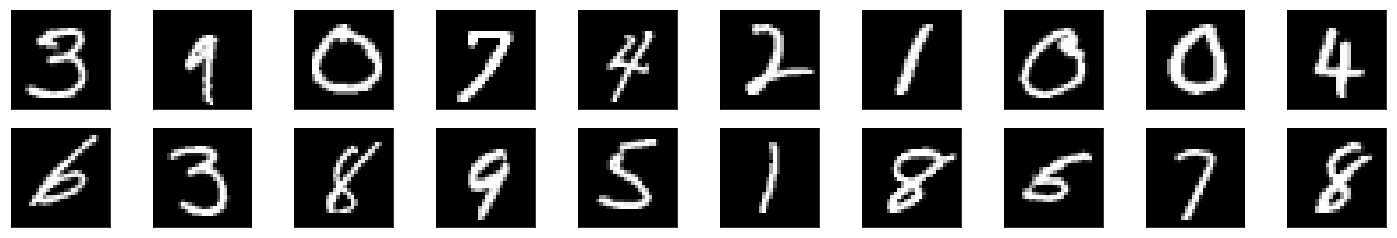

In [7]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, _ = dataiter.next()
images = images.numpy()

random_factor = random.randint(0, batch_size-20) # to show different subset from the dataset each run

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx+random_factor]), cmap='gray')

### Visualize some digits and their center patch (from testing set)

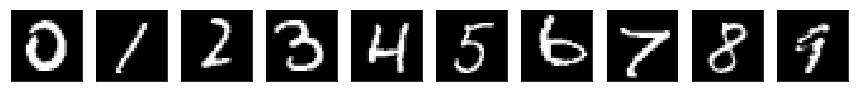

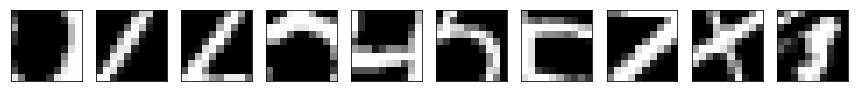

In [8]:
images_out = np.squeeze(get_ten_digits(1))

fig = plt.figure(figsize=(15, 15))
for idx in np.arange(10):
    ax = fig.add_subplot(1, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(images_out[idx], cmap='gray')

images_out = get_digits_mid_window(images_out)

fig = plt.figure(figsize=(15, 15))
for idx in np.arange(10):
    ax = fig.add_subplot(1, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(images_out[idx], cmap='gray')

---
## Define the Model

Discriminator and Generator models

In [9]:
class Discriminator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size, dropout=0.3):
        super(Discriminator, self).__init__()

        self.input_size = input_size
        
        # define all layers
        self.fc1 = nn.Linear(input_size, hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
        
        self.fc4 = nn.Linear(hidden_dim, output_size)
        
        self.lrelu = nn.LeakyReLU(0.2)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout)
        
        
    def forward(self, x):
        # flatten image
        x = x.view(-1, self.input_size)
        
        # apply leaky relu activation to all hidden layers
        x = self.lrelu(self.fc1(x))
        x = self.dropout(x)
        
        x = self.lrelu(self.fc2(x))
        x = self.dropout(x)
        
        x = self.lrelu(self.fc3(x))
        x = self.dropout(x)
        
        x = self.sigmoid(self.fc4(x))

        return x


In [10]:
class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size, dropout=0.3):
        super(Generator, self).__init__()
        
        # define all layers
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        
        self.fc4 = nn.Linear(hidden_dim*4, output_size)
        
        self.lrelu = nn.LeakyReLU(0.2)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(dropout)
        

    def forward(self, x):

        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        
        x = self.fc4(x)
        
        # final layer should have tanh applied
        x = self.tanh(x)
        
        return x

## Model hyperparameters

In [11]:
# Discriminator hyperparams

# Size of input image to discriminator (28*28 + 100)
input_size = 784 + 10*10
# Size of discriminator output (real or fake)
d_output_size = 1
# Size of last hidden layer in the discriminator
d_hidden_size = 100

# Generator hyperparams

# Size of latent vector to give to generator
z_size = 100 + 10*10
# Size of generator output (generated image)
g_output_size = 784
# Size of first hidden layer in the generator
g_hidden_size = 200

## Instantiating the models

In [12]:
# instantiate discriminator and generator
D = Discriminator(input_size, d_hidden_size, d_output_size, dropout=0.5)
G = Generator(z_size, g_hidden_size, g_output_size, dropout=0.3)

# check that they are as you expect
print(D)
print()
print(G)

if(train_on_gpu):
    D.cuda()
    G.cuda()

Discriminator(
  (fc1): Linear(in_features=884, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=1, bias=True)
  (lrelu): LeakyReLU(negative_slope=0.2)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.5)
)

Generator(
  (fc1): Linear(in_features=200, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=800, bias=True)
  (fc4): Linear(in_features=800, out_features=784, bias=True)
  (lrelu): LeakyReLU(negative_slope=0.2)
  (relu): ReLU()
  (tanh): Tanh()
  (dropout): Dropout(p=0.3)
)


## Creating loss functions

### Discriminator Losses
 - For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`.
 - For the real images, we want `D(real_images) = 1`.
 - The discriminator loss for the fake data is similar. We want `D(fake_images) = 0`.

Note: To help the discriminator generalize better, the labels are reduced a bit from 1.0 to 0.9. For this, we'll use the parameter smooth; if True, then we should smooth our labels. In PyTorch, this looks like `labels = torch.ones(size) * 0.9`

$$ \text{The discriminator loss} = BCELoss(D(real\_image),0.9's) \, + \, BCELoss(D(fake\_image),0's) $$


### Generator Loss
- The generator's goal is to get `D(fake_images) = 1` and to minimize the MSE error between the generated image center and the input image center, and to I added a lambda value to control how much we want MSE to influence the total loss.

$$ \text{The generator loss} = BCELoss(D(fake\_image),1's) \, + \, λ*MSELoss(fake\_image_{center},input\_image_{center}) $$

In [13]:
# Calculate losses
def real_loss(D_out, smooth=False):
    # compare logits to real labels
    # smooth labels if smooth=True
    batch_size = D_out.size(0)
    labels = torch.ones(batch_size)
    if smooth:
        labels = labels * 0.9
    
    if(train_on_gpu):
        labels = labels.cuda()
    criterion = nn.BCELoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss


def fake_loss(D_out):
    # compare logits to fake labels
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    if(train_on_gpu):
        labels = labels.cuda()
    criterion = nn.BCELoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss


def generator_loss(D_out, fake_imgs, cond_vecs, my_lambda=10):
    loss1 = real_loss(D_out)

    fake_imgs_cond_vec = fake_imgs.reshape(-1,28,28)[:,10:20,10:20].reshape(-1,100)

    criterion2 = nn.MSELoss()
    loss2 = criterion2(fake_imgs_cond_vec, cond_vecs) * my_lambda

    return loss1, loss2

## Optimizers

We want to update the generator and discriminator variables separately. So, I'll define two separate Adam optimizers.

In [14]:
# learning rate for optimizers
lr = 0.0002

g_weight_decay = 1e-5

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr, weight_decay=g_weight_decay)

---
## Training

### Discriminator training
1. Compute the discriminator loss on real, training images        
2. Generate fake images
3. Compute the discriminator loss on fake, generated images     
4. Add up real and fake loss
5. Perform backpropagation + an optimization step to update the discriminator's weights

### Generator training
1. Generate fake images
2. Compute the discriminator loss on fake images
3. Perform backpropagation + an optimization step to update the generator's weights

#### Saving Samples

As the model is training, I'll also print out some loss statistics and save some generated "fake" samples to keep track of the models' enhancement over epochs.

In [15]:
%%time

# training hyperparams
num_epochs = 100

# keep track of loss, generated ("fake" samples) and accuracy
samples, losses, accuracy = [], [], []


# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size = 1 # 1 for each digit

fixed_z = np.random.uniform(-1, 1, size=(sample_size*10, z_size-100))
cond_vec_fixed = get_digits_mid_window(np.squeeze(get_ten_digits(sample_size))).reshape(-1,100)
fixed_z = np.concatenate((cond_vec_fixed, fixed_z), axis=1)
fixed_z = torch.from_numpy(fixed_z).float()

if(train_on_gpu):
    fixed_z = fixed_z.cuda()

# train the network
D.train()
G.train()
for epoch in range(num_epochs):

    accuracy_real = 0
    accuracy_fake = 0
    
    for batch_i, (real_images, _) in enumerate(train_loader):

        real_images = real_images.detach().numpy()
        cropped_real_images = get_digits_mid_window(real_images)
        real_images = real_images.reshape(-1,28*28)
        real_images = torch.from_numpy(np.array(real_images)).float()

        cropped_real_images = cropped_real_images.reshape(-1,100)
        cropped_real_images = torch.from_numpy(np.array(cropped_real_images)).float()

        if(train_on_gpu):
            real_images = real_images.cuda() 
            cropped_real_images = cropped_real_images.cuda()
                
        batch_size = real_images.size(0)//2
        
        ## rescaling step ## 
        real_images = real_images*2 - 1  # rescale input images from [0,1) to [-1, 1)
        cropped_real_images = cropped_real_images*2 - 1

        real_images_dis = real_images[:batch_size]
        real_images_gen = real_images[-batch_size:]

        cropped_real_images_dis = cropped_real_images[:batch_size]
        cropped_real_images_gen = cropped_real_images[-batch_size:]


        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(cropped_real_images_gen.size(dim=0), z_size-100))
        z = torch.from_numpy(z).float()
        if(train_on_gpu):
            z = z.cuda()

        z = torch.cat((cropped_real_images_gen, z), 1)

        fake_images = G(z)

        fake_images_full = torch.cat((cropped_real_images_gen, fake_images), 1)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        d_fake = D(fake_images_full)

        g_loss1, g_loss2 = generator_loss(d_fake, fake_images
                                            , cropped_real_images_gen, 20)   

        g_loss = g_loss1 + g_loss2
        accuracy_fake += sum(d_fake.detach().cpu().numpy())  
        
        # perform backprop
        g_loss.backward()
        g_optimizer.step()


        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        d_optimizer.zero_grad()
            
        # 1. Train with real images

        # concatenate conditioning vector with real images

        real_images = torch.cat((cropped_real_images_dis, real_images_dis), 1)
        
        d_out = D(real_images)
        accuracy_real += sum(d_out.cpu().detach().numpy())

        # Compute the discriminator losses on real images
        # use smoothed labels
        r_loss = real_loss(d_out, True)             
        
        
        # 2. Train with fake images
        # Generate fake images and concatenating its conditioning vector
        z = np.random.uniform(-1, 1, size=(cropped_real_images_dis.size(dim=0), z_size-100))
        z = torch.from_numpy(z).float()
        if(train_on_gpu):
            z = z.cuda()

        z = torch.cat((cropped_real_images_dis, z), 1)
        
        fake_images = G(z)

        fake_images = torch.cat((cropped_real_images_dis, fake_images), 1)
        
        # Compute the discriminator losses on fake images        
        d_out = D(fake_images)
        f_loss = fake_loss(d_out)
        
        # add up real and fake losses and perform backprop
        d_loss = r_loss + f_loss
        
        d_loss.backward()
        d_optimizer.step()
        
    ## AFTER EACH EPOCH##

    # append discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))
    # append real image accuracy and fake image accuracy
    accuracy_real /= training_set_count//2
    accuracy_fake /= training_set_count//2
    accuracy.append((accuracy_real[0], accuracy_fake[0]))

    print('Epoch [{:3d}/{:3d}] | accuracy_real : {:0.6f} | accuracy_fake: {:0.6f}'.format(
            epoch+1, num_epochs, accuracy_real[0], accuracy_fake[0]))


    # print discriminator and generator loss
    print('Epoch [{:3d}/{:3d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
            epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to train mode

    exit_flag = 0
    try:
        for ii in range(5):
            if accuracy_fake[-ii] < accuracy_fake[-ii-1]:
                exit_flag -= 1
                break
            else:
                exit_flag += 1
    except:
        exit_flag = 0
    
    if exit_flag == 5:
        break


Epoch [  1/100] | accuracy_real : 0.811367 | accuracy_fake: 0.094836
Epoch [  1/100] | d_loss: 0.8942 | g_loss: 10.6463
Epoch [  2/100] | accuracy_real : 0.761230 | accuracy_fake: 0.085600
Epoch [  2/100] | d_loss: 0.8008 | g_loss: 8.1397
Epoch [  3/100] | accuracy_real : 0.604791 | accuracy_fake: 0.268999
Epoch [  3/100] | d_loss: 0.9682 | g_loss: 5.2776
Epoch [  4/100] | accuracy_real : 0.632781 | accuracy_fake: 0.240879
Epoch [  4/100] | d_loss: 1.2924 | g_loss: 4.2548
Epoch [  5/100] | accuracy_real : 0.667840 | accuracy_fake: 0.214702
Epoch [  5/100] | d_loss: 0.7368 | g_loss: 5.0413
Epoch [  6/100] | accuracy_real : 0.638856 | accuracy_fake: 0.256978
Epoch [  6/100] | d_loss: 1.0813 | g_loss: 4.2059
Epoch [  7/100] | accuracy_real : 0.618811 | accuracy_fake: 0.276060
Epoch [  7/100] | d_loss: 0.9985 | g_loss: 3.7159
Epoch [  8/100] | accuracy_real : 0.601036 | accuracy_fake: 0.300656
Epoch [  8/100] | d_loss: 1.2266 | g_loss: 3.5205
Epoch [  9/100] | accuracy_real : 0.588639 | ac

In [16]:
# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

## Training loss

Here will plot the training losses for the generator and discriminator, recorded after each epoch.

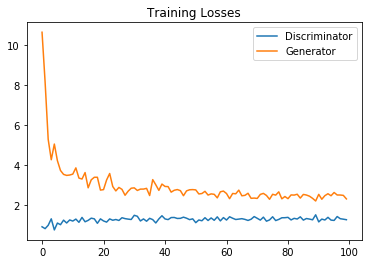

In [17]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend();

## Training accuracy

Here will plot the classification accuracy, recorded after each epoch.

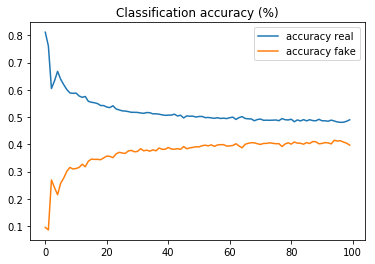

In [18]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(np.array(accuracy).T[0], label='accuracy real')
plt.plot(np.array(accuracy).T[1], label='accuracy fake')
plt.title("Classification accuracy (%)")
plt.legend();

## Generator samples from training

Here will can view samples of images from the generator. First we'll look at the images we saved during training.

In [19]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(15,15), nrows=1, ncols=10, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.cpu().reshape((28,28)), cmap='Greys_r')

In [20]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

Below I'm showing the generated images as the network was training, every 5 epochs.

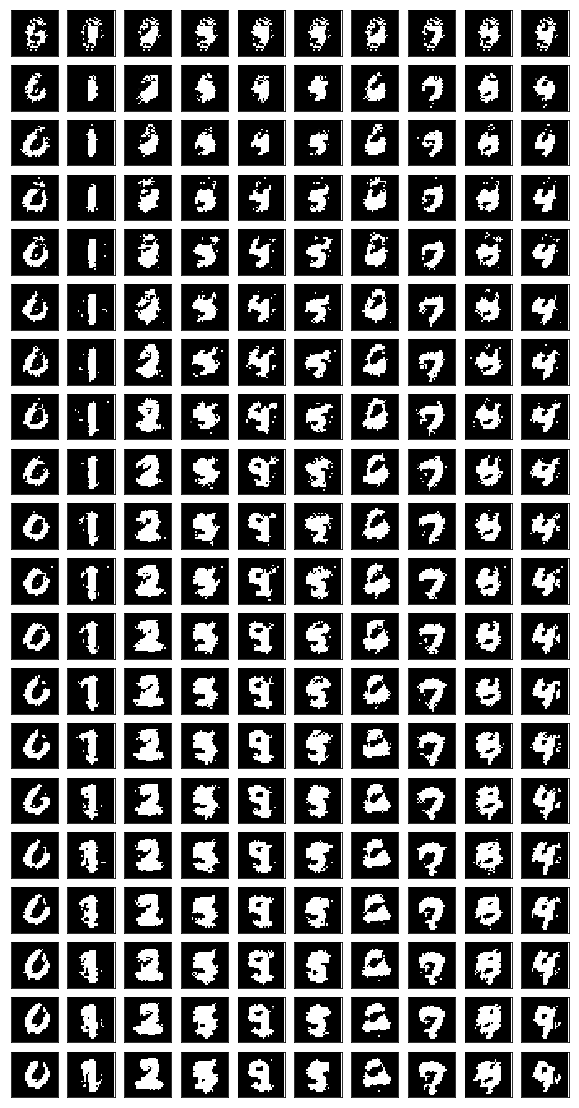

In [42]:
rows = len(samples)//5 # generated images every 5 epochs
cols = 10
fig, axes = plt.subplots(figsize=(10,20), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach().cpu()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

## Generating 10 sample for ech digit

Generating new images from the generator . just need to pass in a new latent vector $z$, plus the conditioning vector and we'll get new samples

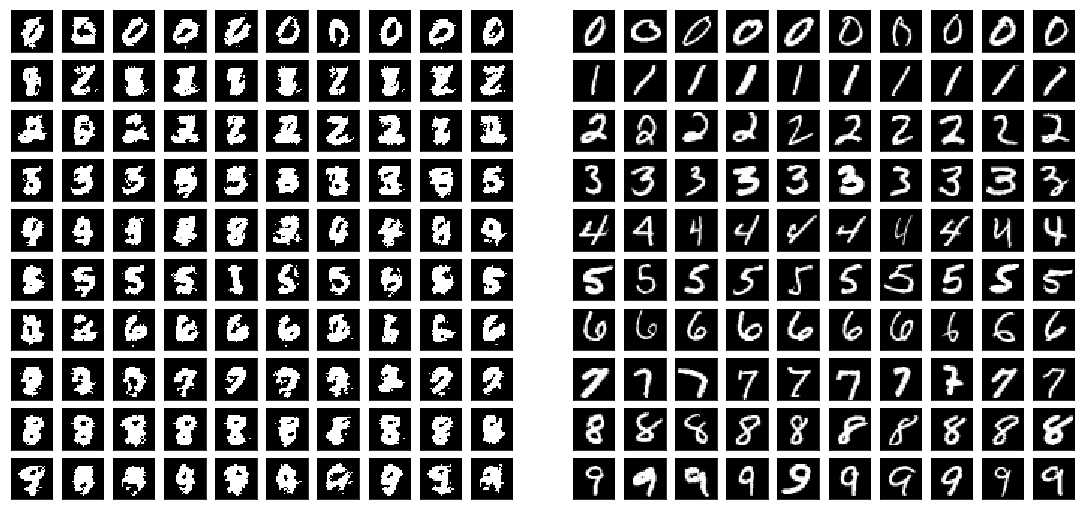

In [49]:
sample_size = 10
z = np.random.uniform(-1, 1, size=(sample_size*10, z_size-100))
real_images = np.squeeze(get_ten_digits(sample_size))
cond_vec_fixed = get_digits_mid_window(real_images).reshape(-1,100)
z = np.concatenate((cond_vec_fixed, z), axis=1)
z = torch.from_numpy(z).float()
if(train_on_gpu):
    z = z.cuda()

G.eval() # eval mode
fake_images = G(z)

fig = plt.figure(figsize=(20,9))
for i in range(10):
    for j in range(10):
        ax = fig.add_subplot(10, 22, i*22 + j + 1, xticks=[], yticks=[])
        ax.imshow(fake_images[j*10 + i].cpu().detach().numpy().reshape(28,28), cmap='gray');

        ax = fig.add_subplot(10, 22, i*22 + j + 12, xticks=[], yticks=[])
        ax.imshow(real_images[j,i], cmap='gray');